## Importing Library

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from datetime import datetime, timedelta, date

import math

## Dataset

### Importing Dataset

In [3]:
# Downloading the data
aapl_df = yf.download('AAPL')
aapl_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099874,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094663,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087715,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089886,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092492,73449600


### Data Preprocessing

In [4]:
# Removing Adj Close and Volume column
aapl_df = aapl_df.drop(['Adj Close', 'Volume'], axis=1)

# Adding a column 'Prediction' which is shifted by 1 day
aapl_df['Prediction'] = aapl_df['Close'].shift(-1)

# Removing NA values
aapl_df = aapl_df.dropna()

aapl_df.head()

,Open,High,Low,Close,Prediction
Date,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.121652
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.112723
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.115513
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.118862
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.126116


In [5]:
# Extract dates for the test dataset
x_date = aapl_df.index[-math.ceil(len(aapl_df) * 0.3):]

In [6]:
# Scaling the data
scaler = MinMaxScaler()
aapl_df = scaler.fit_transform(np.array(aapl_df).reshape(-1, 1))
aapl_df = pd.DataFrame(aapl_df.reshape(-1, 5),
                       columns=['Open', 'High', 'Low', 'Close', 'Prediction']
                    )

# Seperating and Scaling the data
x = aapl_df.drop(['Prediction'], axis=1)
y = aapl_df['Prediction']

# Splitting the data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=False)

## Model Building and Training

In [7]:
model = RandomForestRegressor(n_estimators=500, 
                              random_state=0,
                            )
model.fit(x_train, y_train)


RandomForestRegressor(n_estimators=500, random_state=0)

## Model Evaluation

In [8]:
# Predicting the data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.values.reshape(-1, 1))

# Calculating the error
error = predictions - y_test
mse = np.square(error).mean()
rmse = np.sqrt(mse)
mae = np.abs(error).mean()
mape = np.abs(error / y_test).mean() * 100

# Printing the error
print('Mean Squared Error: ', mse)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)


Mean Squared Error:  4161.08806971377
Root Mean Squared Error:  64.50649633729745
Mean Absolute Error:  43.518998619319206
Mean Absolute Percentage Error:  65.88181490827061


## Model Prediction and Visualization

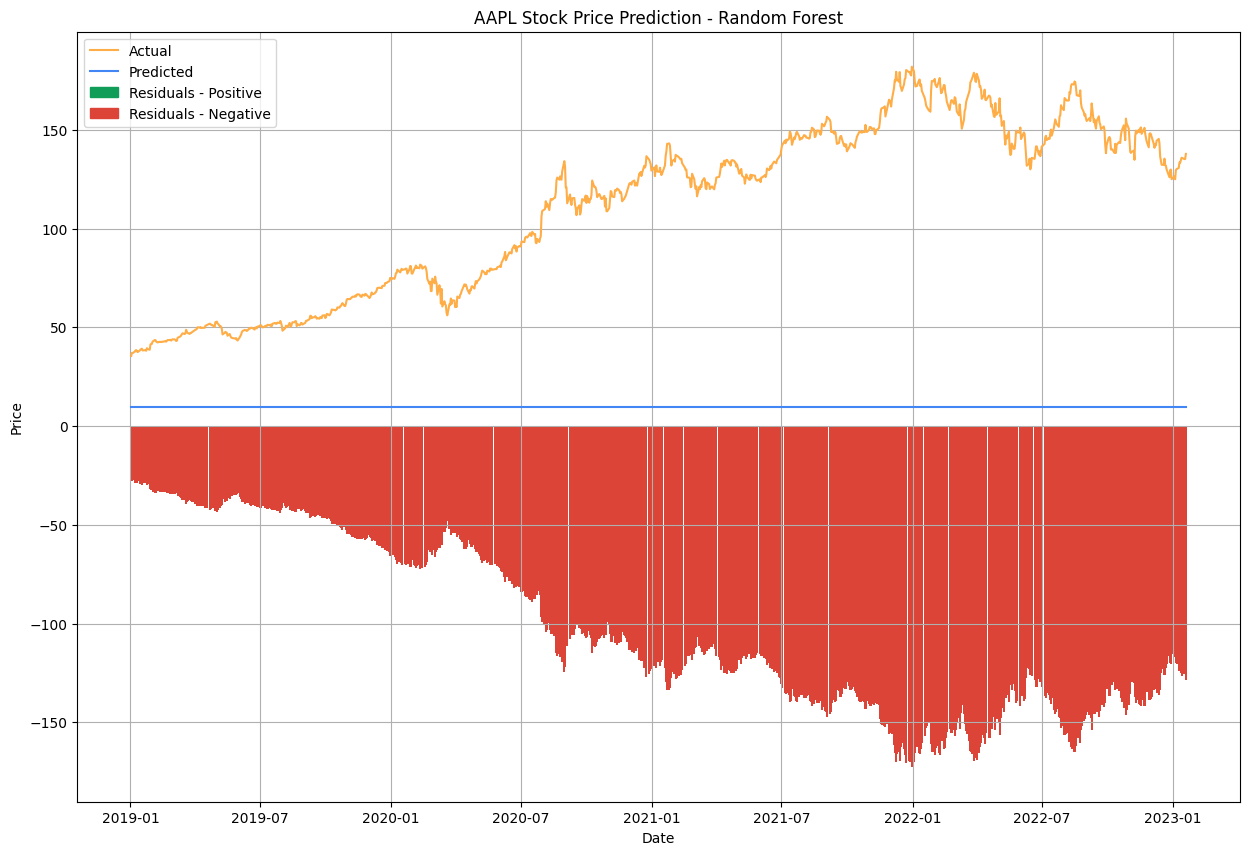

In [9]:
# Creating a dataframe for the predictions with actual values and residuals with dates
predictions_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': predictions.flatten(), 'Residuals': error.flatten()}, index=x_date)

# Taking data from 2019-01-01
predictions_df = predictions_df.loc['2019-01-01':]

# Plotting the data and residuals bars in the same plot
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(predictions_df.index,
        predictions_df['Actual'], label='Actual', color='#FFAD46', linewidth=1.5)
ax.plot(predictions_df.index, predictions_df['Predicted'], label='Predicted', color='#4285F4', linewidth=1.5)

df_sub = ["#0F9D58" if x >
          0 else "#DB4437" for x in predictions_df["Residuals"].dropna()]
ax.bar(predictions_df.index, predictions_df['Residuals'].dropna(), width=3, label='Residuals', color=df_sub)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('AAPL Stock Price Prediction - Random Forest')

Patch = mpatches.Patch
legend_elements = [Line2D([0], [0], color='#FFAD46', lw=1.5, label='Actual'),
                   Line2D([0], [0], color='#4285F4',
                          lw=1.5, label='Predicted'),
                   Patch(facecolor='#0F9D58', edgecolor='#0F9D58',
                         label='Residuals - Positive'),
                   Patch(facecolor='#DB4437', edgecolor='#DB4437', label='Residuals - Negative')]
ax.legend(handles=legend_elements, loc='upper left')

ax.grid(True)
plt.show()